# SonarNet: U-Net Based Architecture

Author: Matt Slivinski

Our model is based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf).

## Imports

In [32]:
import os
import sys
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imshow
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

## Globals

In [33]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 25
TRAIN_PATH = '../../GeneratedData/train_0/'
TEST_PATH = '../../GeneratedData/test/'

seed = 42
random.seed = seed
np.random.seed = seed

## Data Pre-processing

In [34]:
# Get train and test ids
train_ids = np.loadtxt(TRAIN_PATH + 'Directory.txt').astype(int)
test_ids = np.loadtxt(TEST_PATH + 'Directory.txt').astype(int)

In [35]:
# Print ids
# print("train ids(%i):" % (len(train_ids)), train_ids, "\n")
# print("test ids(%i):" % (len(test_ids)), test_ids)

In [36]:
# Initialize training and testing variables
X_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
X_test = np.zeros((len(test_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# Get training images and true masks
print('Getting training images and true masks ... ')
sys.stdout.flush()
for n, id in tqdm(enumerate(train_ids), total=len(train_ids)):
    # Get image
    img_path = TRAIN_PATH + 'ImageMap-' + str(id) + '.dat'
    img_zxy = np.fromfile(img_path, dtype='uint8')
    img_zxy.shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
    
    # Reshape image from 25x64x64 to 64x64x25
    img_xyz = np.zeros((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    for i in range(IMG_CHANNELS):
        img_xyz[:,:,i] = img_zxy[i,:,:]
    X_train[n] = img_xyz
    
    # Get true mask
    mask_path = TRAIN_PATH + 'LabelMap-' + str(id) + '.dat'
    mask = np.fromfile(mask_path, dtype=np.bool)
    mask.shape = (IMG_WIDTH, IMG_HEIGHT, 1)
    Y_train[n] = mask

# Get testing images and true masks
print('Getting testing images and true masks ... ')
sys.stdout.flush()
for n, id in tqdm(enumerate(test_ids), total=len(test_ids)):
    # Get image
    img_path = TEST_PATH + 'ImageMap-' + str(id) + '.dat'
    img_zxy = np.fromfile(img_path, dtype='uint8')
    img_zxy.shape = (IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT)
    
    # Reshape image from 25x64x64 to 64x64x25
    img_xyz = np.zeros((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    for i in range(IMG_CHANNELS):
        img_xyz[:,:,i] = img_zxy[i,:,:]
    X_test[n] = img_xyz
    
    # Get true mask
    mask_path = TEST_PATH + 'LabelMap-' + str(id) + '.dat'
    mask = np.fromfile(mask_path, dtype=np.bool)
    mask.shape = (IMG_WIDTH, IMG_HEIGHT, 1)
    Y_test[n] = mask

print("Done!")

Getting training images and true masks ... 


100%|██████████| 5000/5000 [00:03<00:00, 1300.11it/s]

Getting testing images and true masks ... 



100%|██████████| 500/500 [00:00<00:00, 1276.14it/s]

Done!


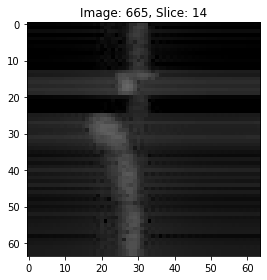

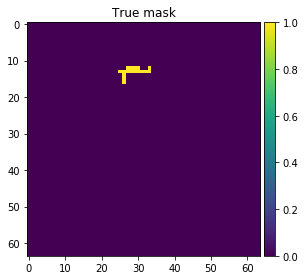

In [37]:
# Check how the training images look
img_idx = random.randint(0, len(train_ids)-1)
color_idx = random.randint(0, IMG_CHANNELS-1)

img_title = "Image: " + str(img_idx) + ", Slice: " + str(color_idx)
plt.title(img_title)
imshow(X_train[img_idx,:,:,color_idx])
plt.show()

plt.title("True mask")
imshow(np.squeeze(Y_train[img_idx]))
plt.show()

## Model

In [38]:
# Normalize inputs
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

# Encoder layers
conv0 = Conv2D(4, (3, 3), activation='relu', padding='same') (s)
conv0 = Dropout(0.2)(conv0)
conv0 = Conv2D(4, (3, 3), activation='relu', padding='same') (conv0)
pool0 = MaxPooling2D((2, 2)) (conv0)

conv1 = Conv2D(8, (3, 3), activation='relu', padding='same') (pool0)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same') (conv1)
pool1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same') (pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same') (conv2)
pool2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same') (pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same') (conv3)
pool3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same') (pool3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same') (conv4)

# Decoder layers
upconv7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv4)
upconv7 = concatenate([upconv7, conv3])
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same') (upconv7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same') (conv7)

upconv8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv7)
upconv8 = concatenate([upconv8, conv2])
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same') (upconv8)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same') (conv8)

upconv9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (conv8)
upconv9 = concatenate([upconv9, conv1])
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same') (upconv9)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same') (conv9)

upconv10 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same') (conv9)
upconv10 = concatenate([upconv10, conv0], axis=3)
conv10 = Conv2D(4, (3, 3), activation='relu', padding='same') (upconv10)
conv10 = Conv2D(4, (3, 3), activation='relu', padding='same') (conv10)

# Output activation
outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv10)

W0827 09:25:14.614538 140237959726912 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/unet_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 09:25:14.644956 140237959726912 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/unet_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 09:25:14.660600 140237959726912 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/unet_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 09:25:14.679473 140237959726912 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/unet_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_defa

In [39]:
# Init, compile, and show summary of the model
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

W0827 09:25:18.789516 140237959726912 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/unet_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 09:25:18.821865 140237959726912 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/unet_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0827 09:25:18.827259 140237959726912 deprecation.py:323] From /home/admin/anaconda3/envs/unet_env/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 25)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64, 25)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 4)    904         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 64, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (


## Training

In [40]:
# Stop early if loss hasn't changed
earlystopper = EarlyStopping(patience=5, verbose=1)

# Save best check points
checkpointer = ModelCheckpoint('SonarNet-UNet.h5', verbose=1, save_best_only=True)

# Fit model on training data
results = model.fit(X_train, Y_train, validation_split=0.25, batch_size=8, epochs=30, 
                   callbacks=[earlystopper, checkpointer])

Train on 3750 samples, validate on 1250 samples
Epoch 1/30
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0642 - acc: 0.9768 - val_loss: 0.0140 - val_acc: 0.9961

Epoch 00001: val_loss improved from inf to 0.01399, saving model to SonarNet-UNet.h5
Epoch 2/30
1136/3750 [========>.....................] - ETA: 19s - loss: 0.0133 - acc: 0.9960

KeyboardInterrupt: 

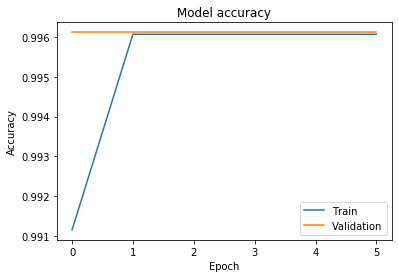

In [13]:
# Plot training & validation accuracy values
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

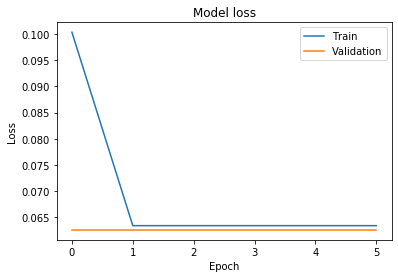

In [11]:
# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Prediction

In [14]:
# Predict on train, validation and test data
model = load_model('model-SonarNet-1.h5', custom_objects={})

pred_train = model.predict(X_train[:int(X_train.shape[0]*0.75)], verbose=1)
pred_val = model.predict(X_train[int(X_train.shape[0]*0.75):], verbose=1)
pred_test = model.predict(X_test, verbose=1)

# Threshold predictions
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)

500/500 [==============================] - 1s 2ms/step


# Detection

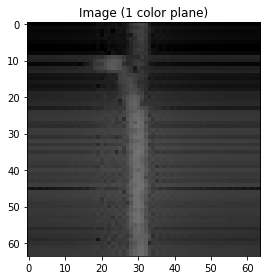

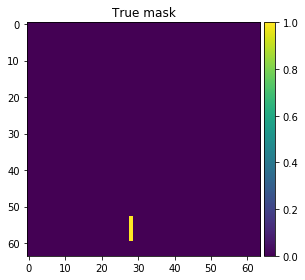

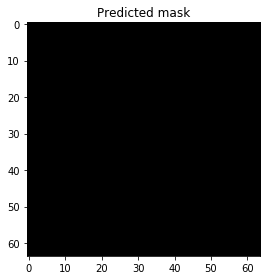

In [25]:
# Check how training predictions look
img_idx = random.randint(0, len(pred_train)-1)
color_idx = random.randint(0, IMG_CHANNELS-1)

imshow(X_train[img_idx,:,:,color_idx])
plt.title("Image (1 color plane)")
plt.tight_layout()
plt.show()

plt.title("True mask")
imshow(np.squeeze(Y_train[img_idx]))
plt.show()

plt.title("Predicted mask")
imshow(np.squeeze(pred_train[img_idx]))
plt.show()

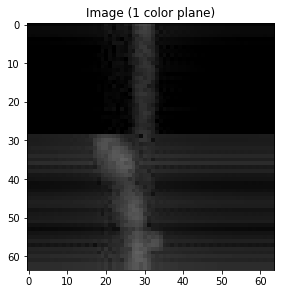

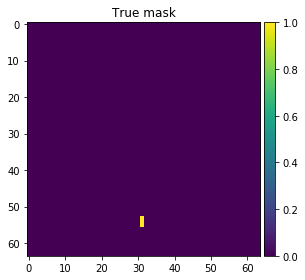

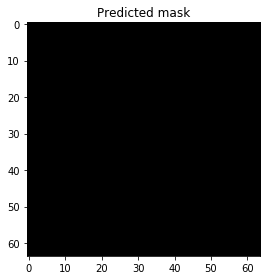

In [28]:
# Check how validation predictions look
img_idx = random.randint(0, len(pred_val)-1)
color_idx = random.randint(0, IMG_CHANNELS-1)

imshow(X_train[img_idx,:,:,color_idx])
plt.title("Image (1 color plane)")
plt.show()
plt.title("True mask")
imshow(np.squeeze(Y_train[img_idx]))
plt.show()
plt.title("Predicted mask")
imshow(np.squeeze(pred_train[img_idx]))
plt.show()

## Evaluate

In [30]:
# Evalute on test data
loss, accuracy = model.evaluate(X_test, Y_test)

500/500 [==============================] - 1s 3ms/step


In [31]:
# Print the loss and accuracy scores
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Loss:  0.06887186592817307
Accuracy:  0.99572705078125


---

## Test code

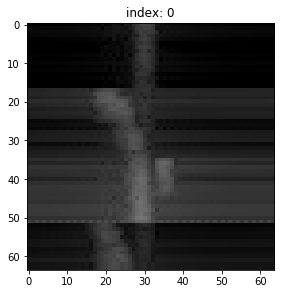

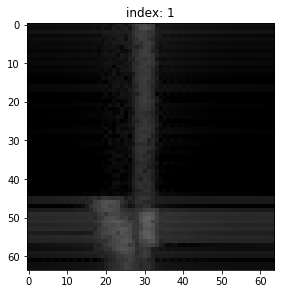

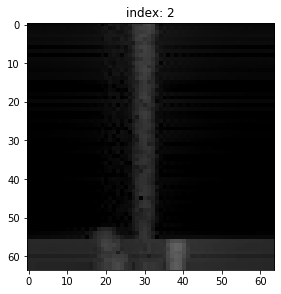

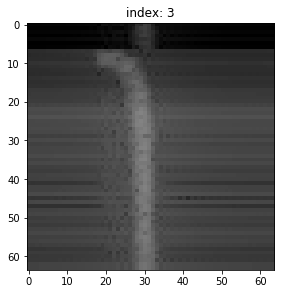

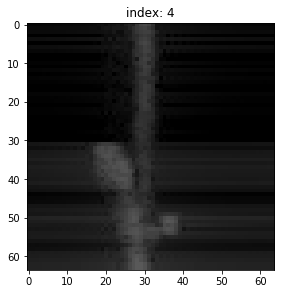

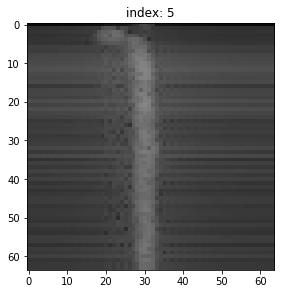

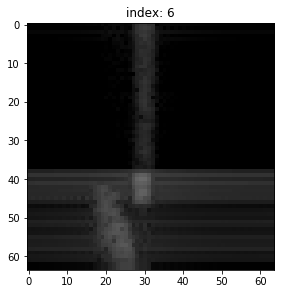

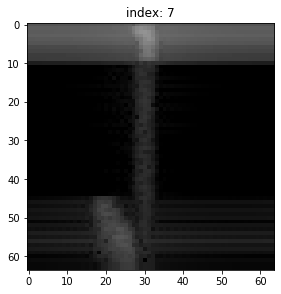

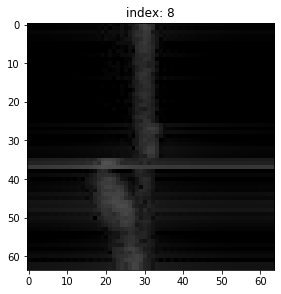

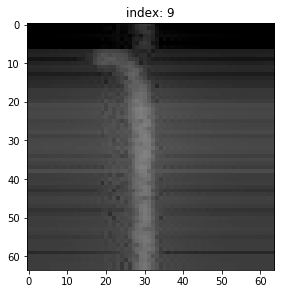

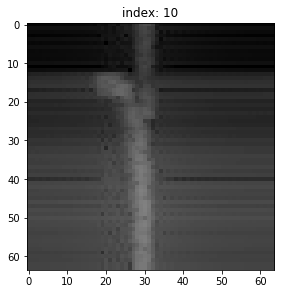

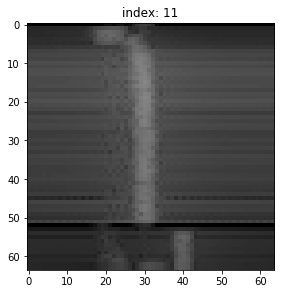

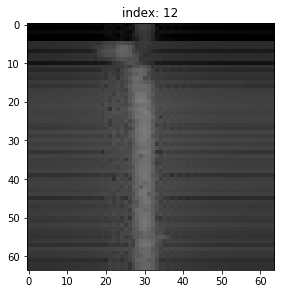

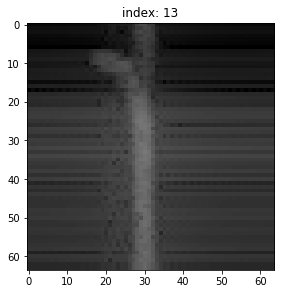

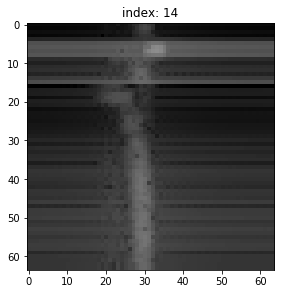

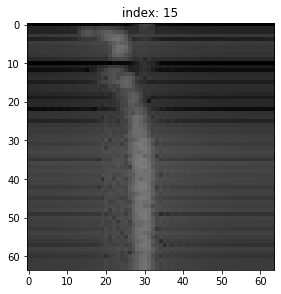

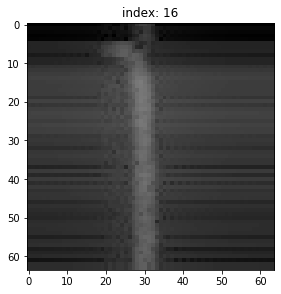

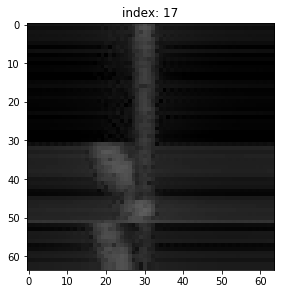

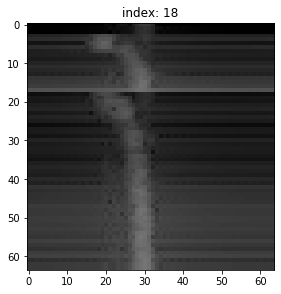

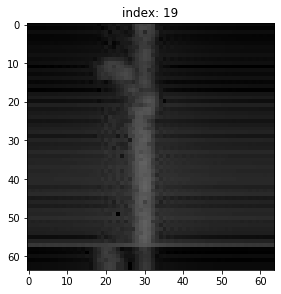

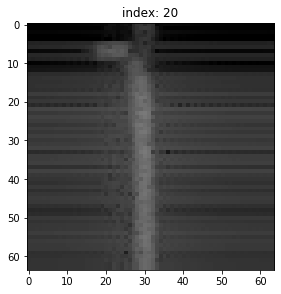

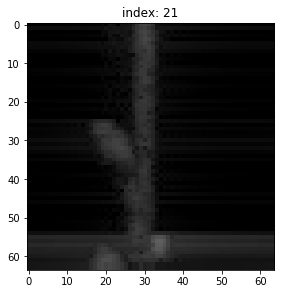

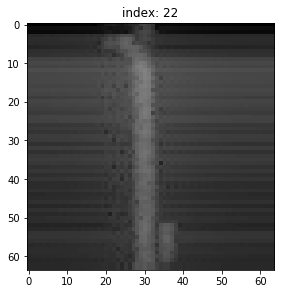

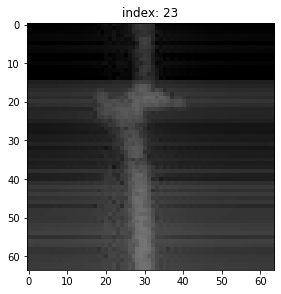

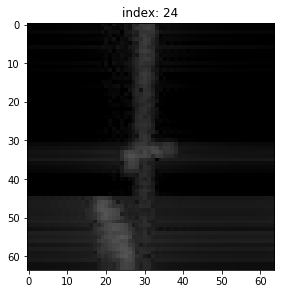

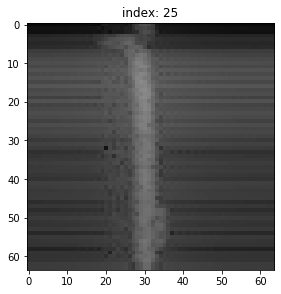

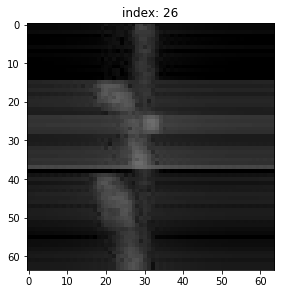

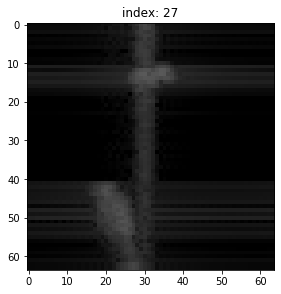

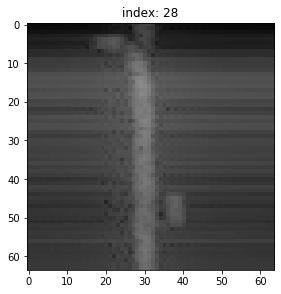

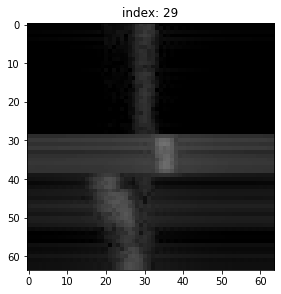

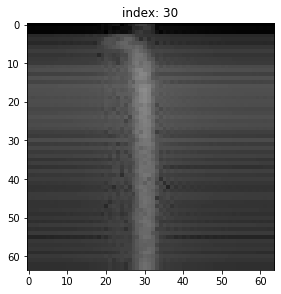

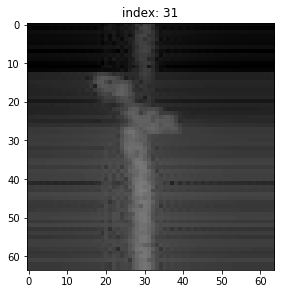

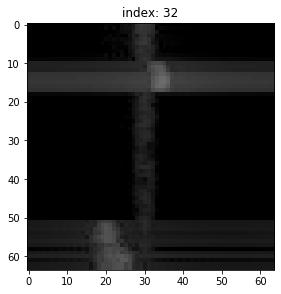

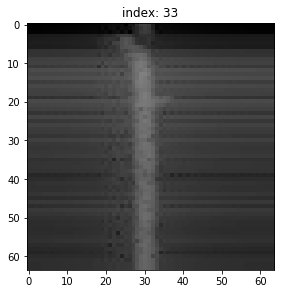

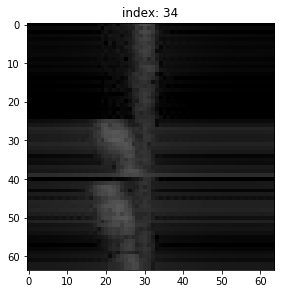

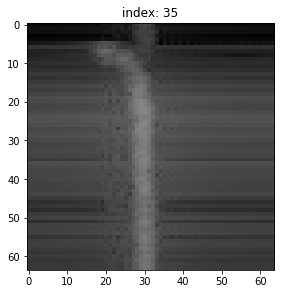

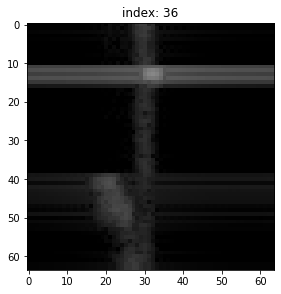

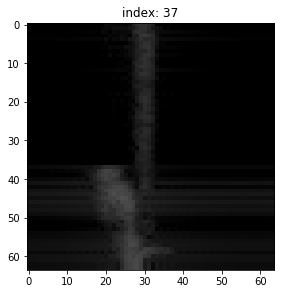

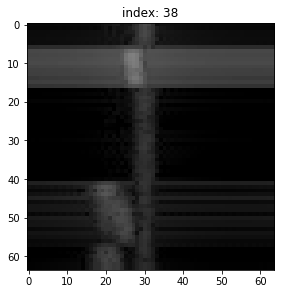

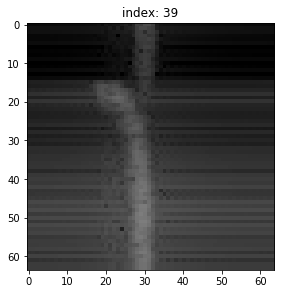

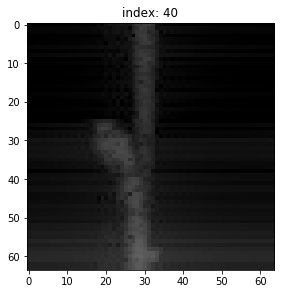

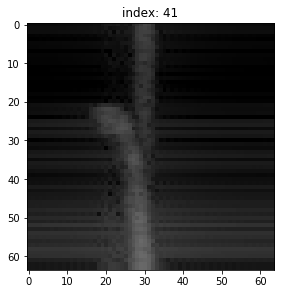

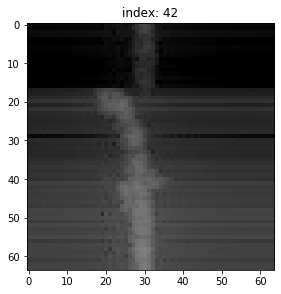

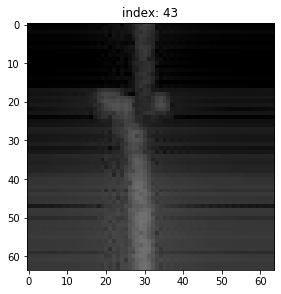

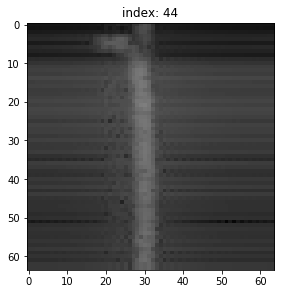

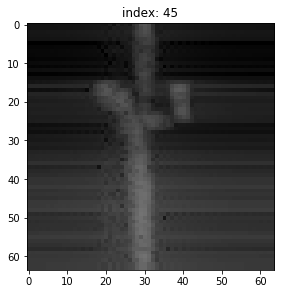

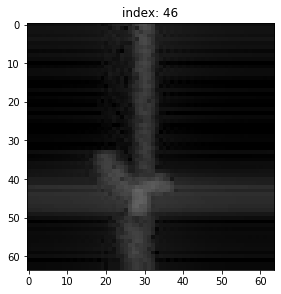

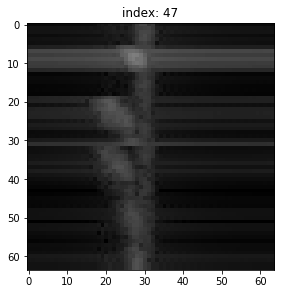

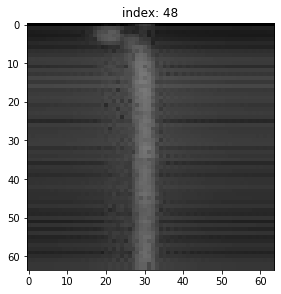

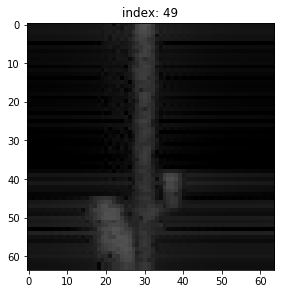

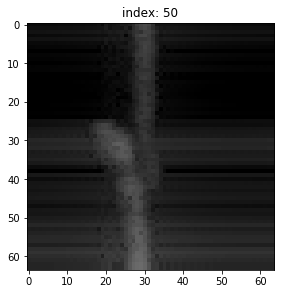

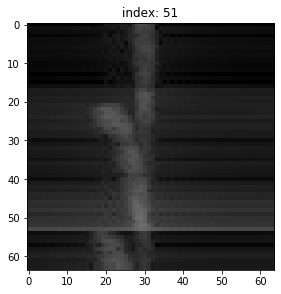

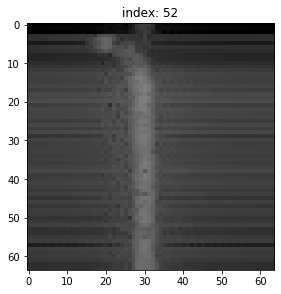

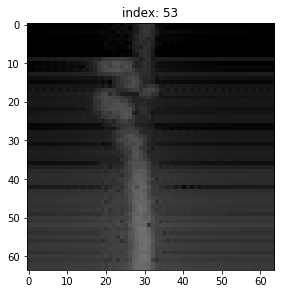

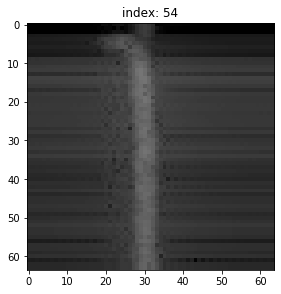

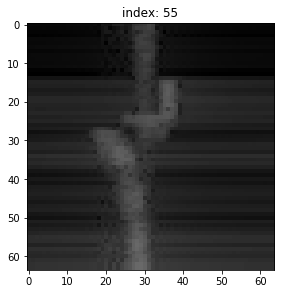

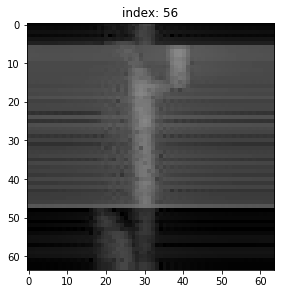

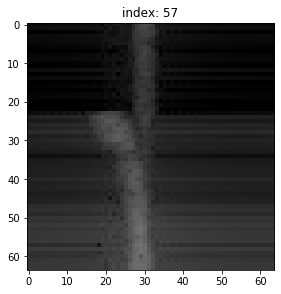

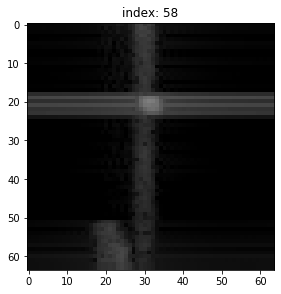

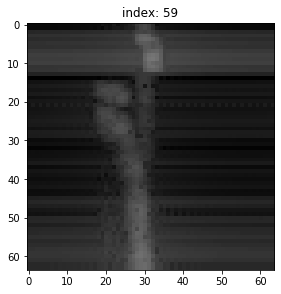

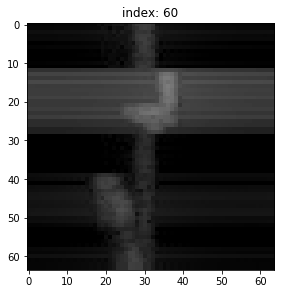

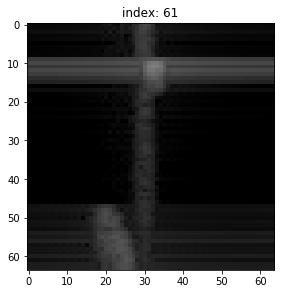

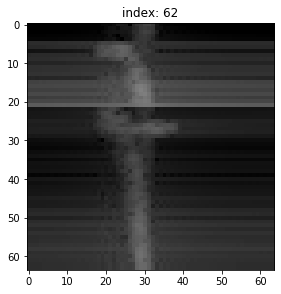

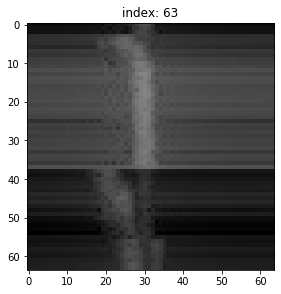

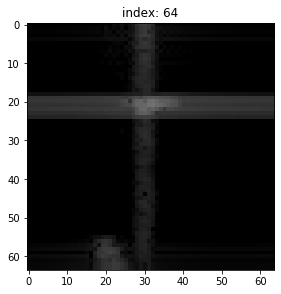

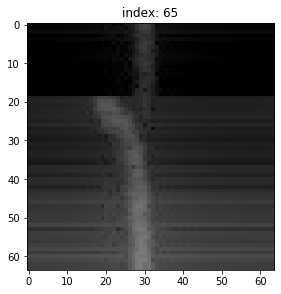

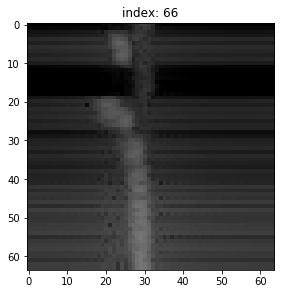

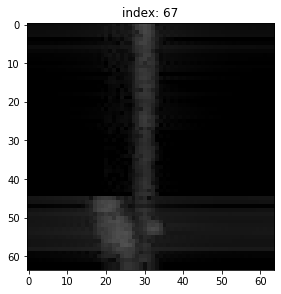

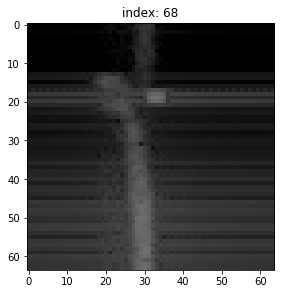

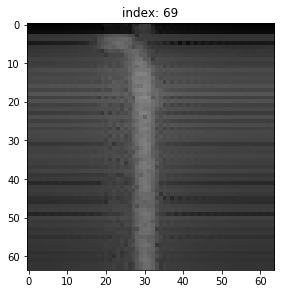

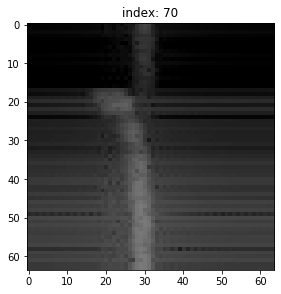

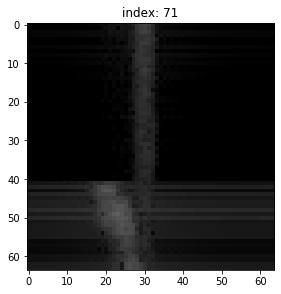

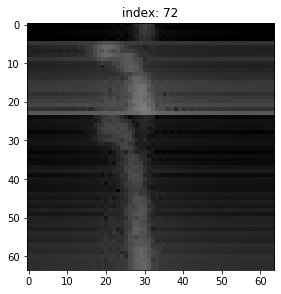

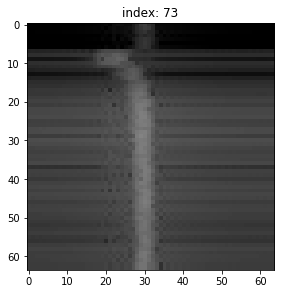

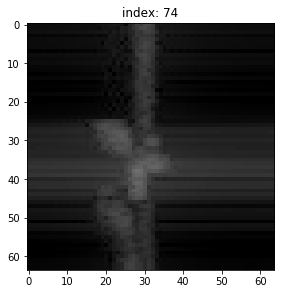

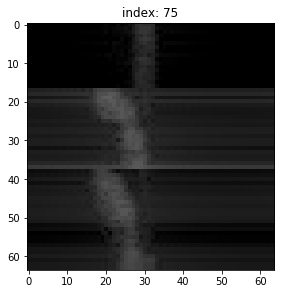

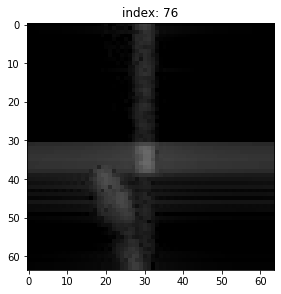

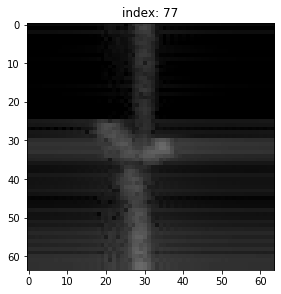

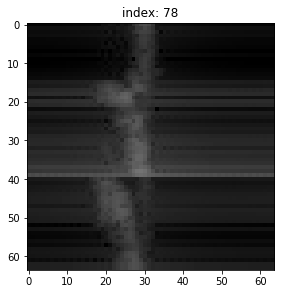

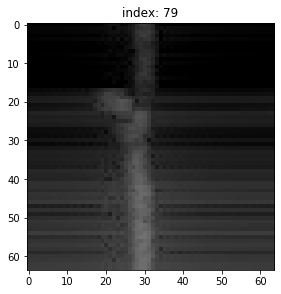

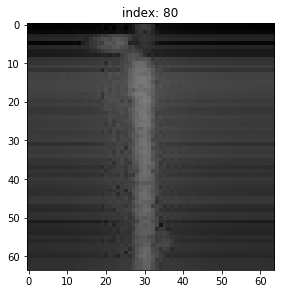

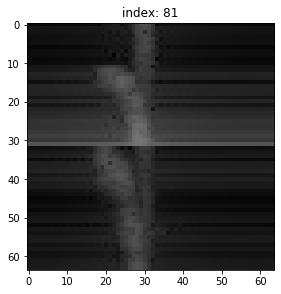

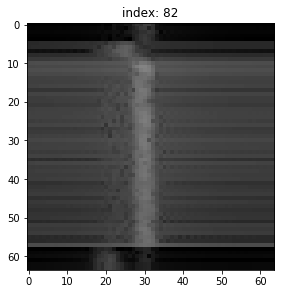

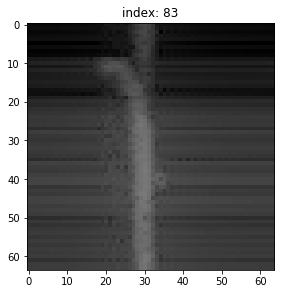

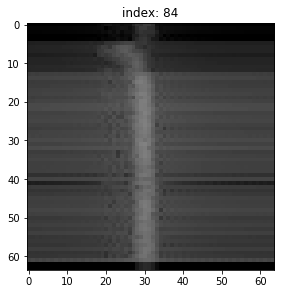

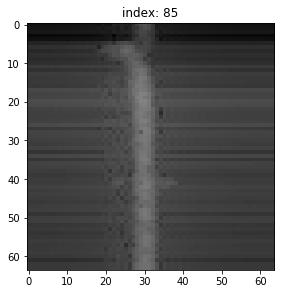

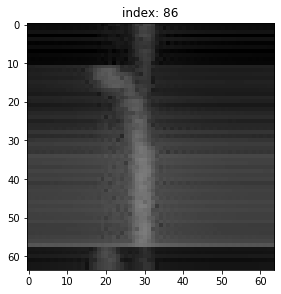

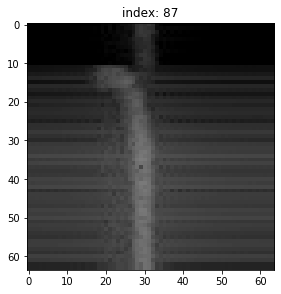

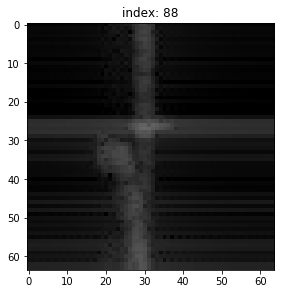

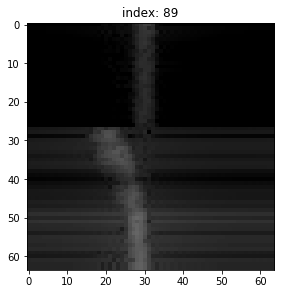

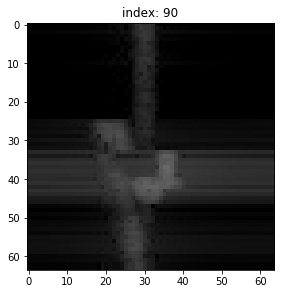

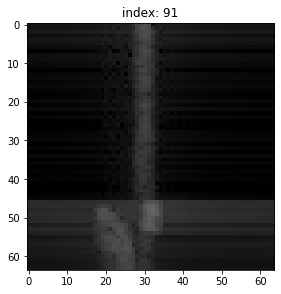

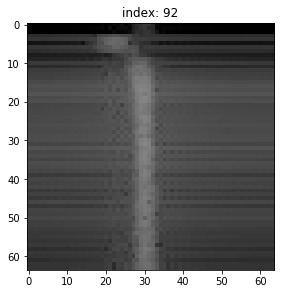

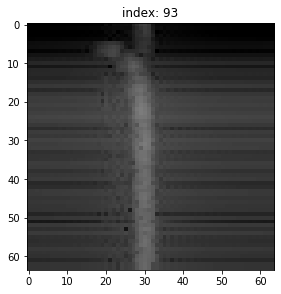

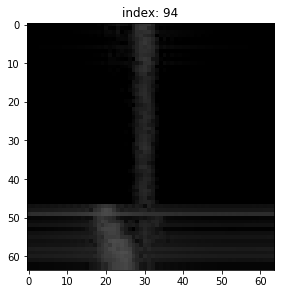

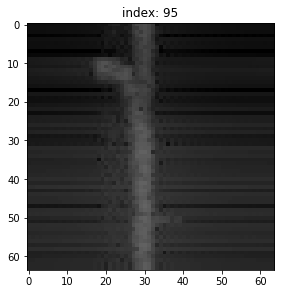

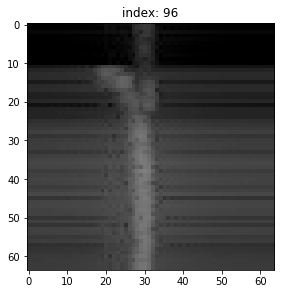

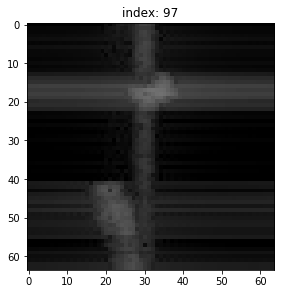

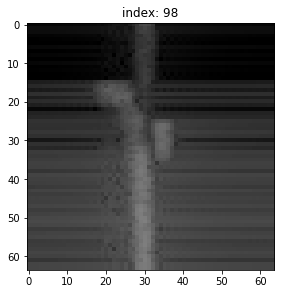

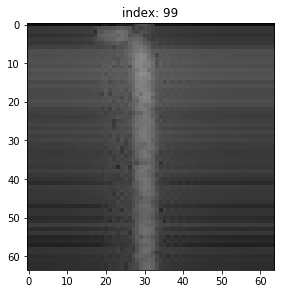

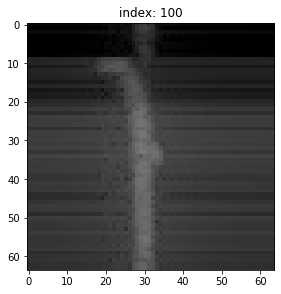

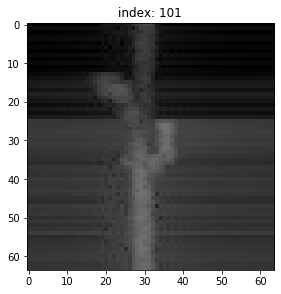

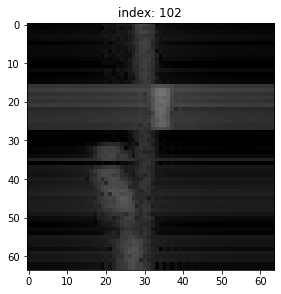

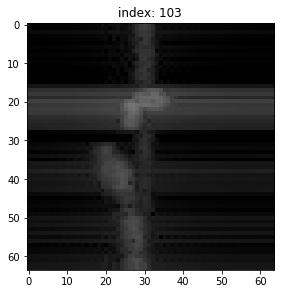

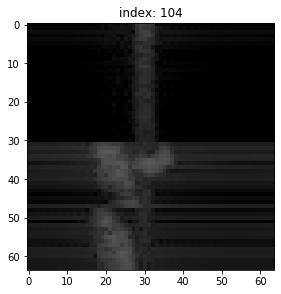

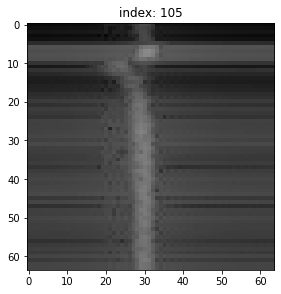

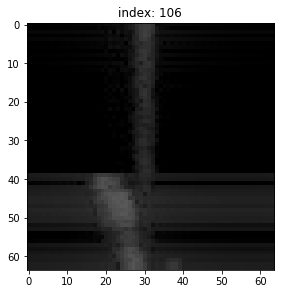

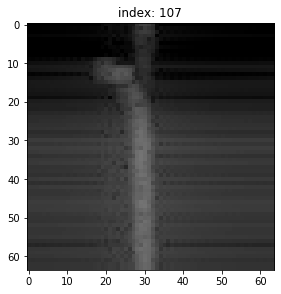

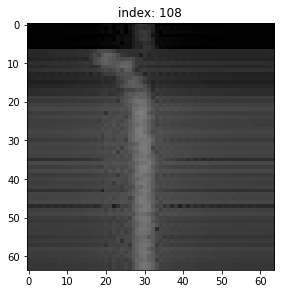

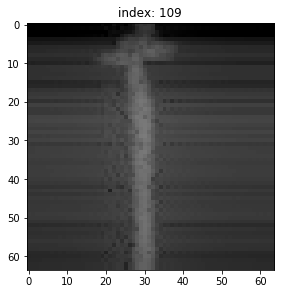

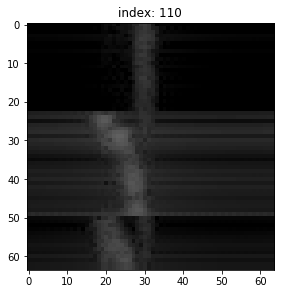

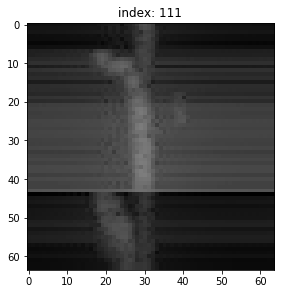

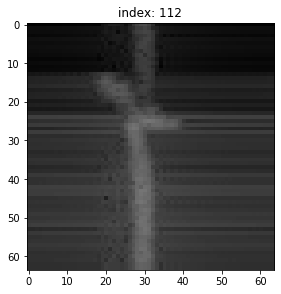

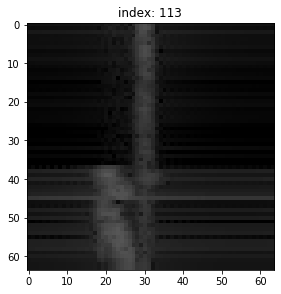

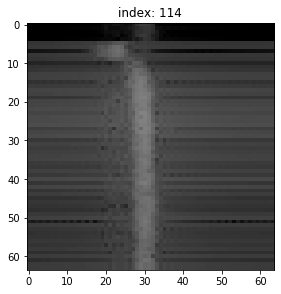

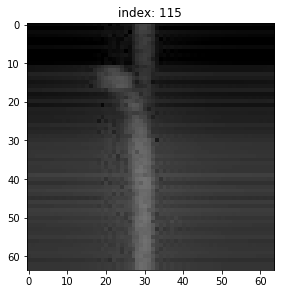

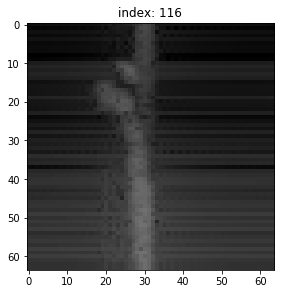

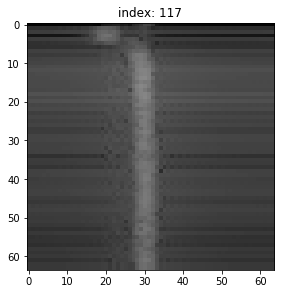

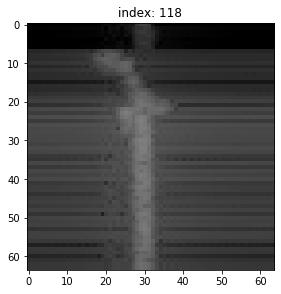

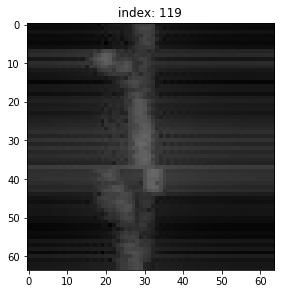

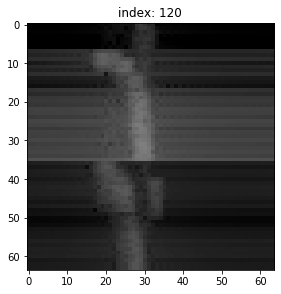

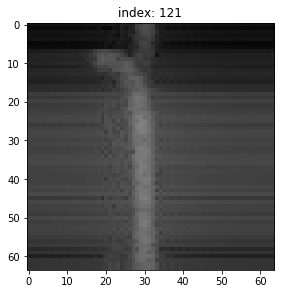

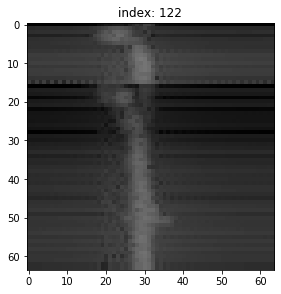

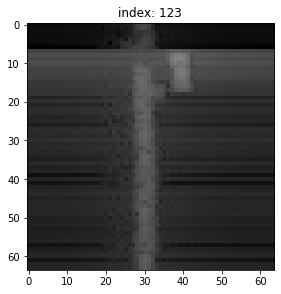

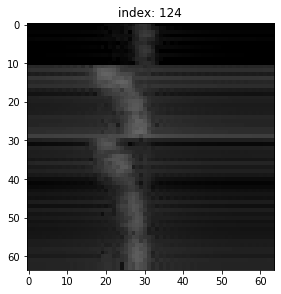

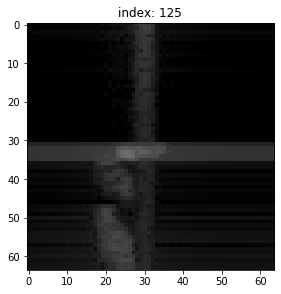

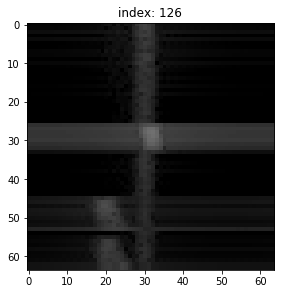

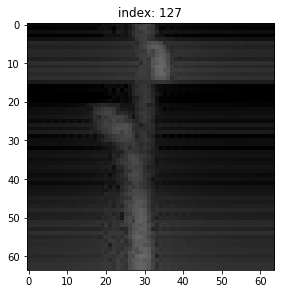

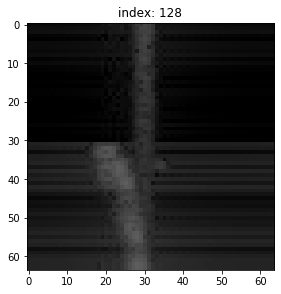

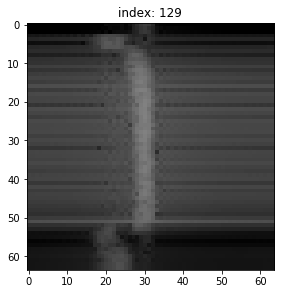

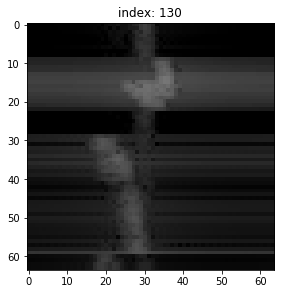

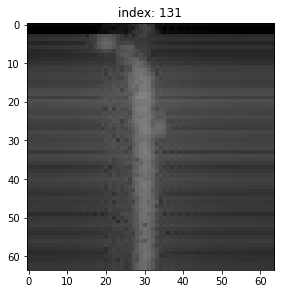

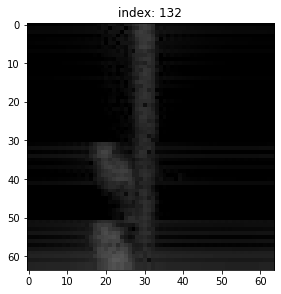

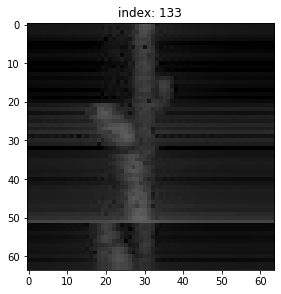

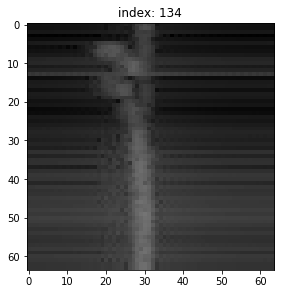

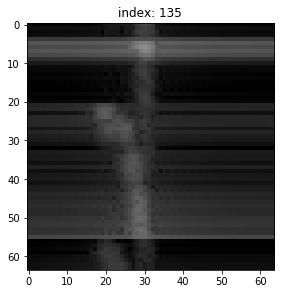

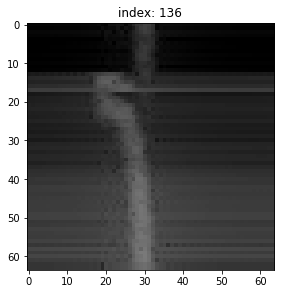

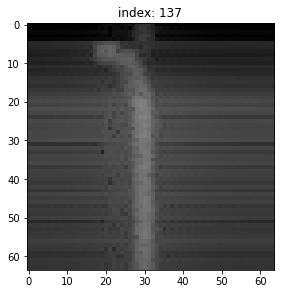

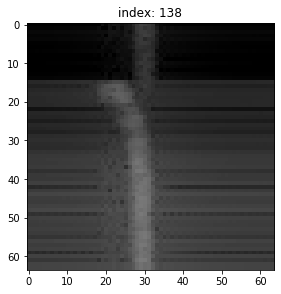

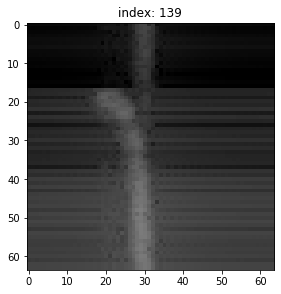

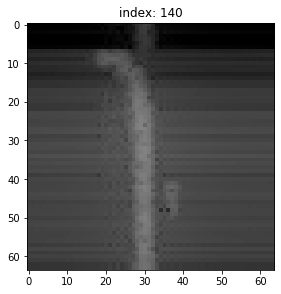

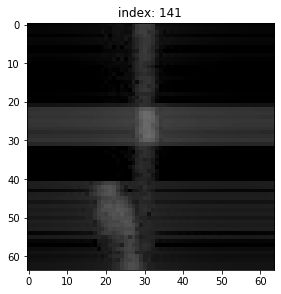

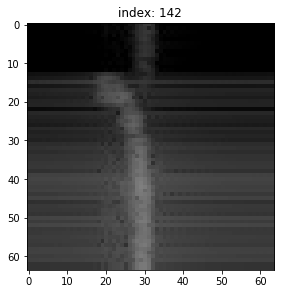

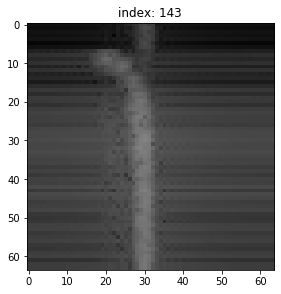

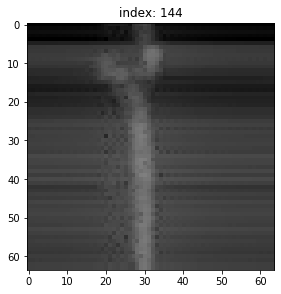

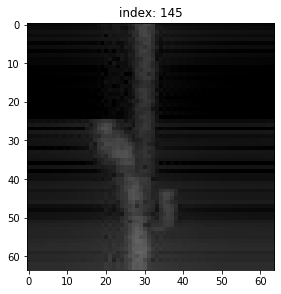

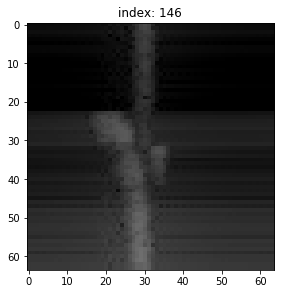

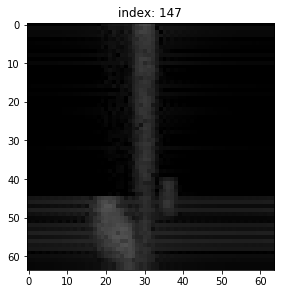

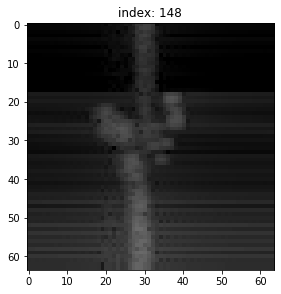

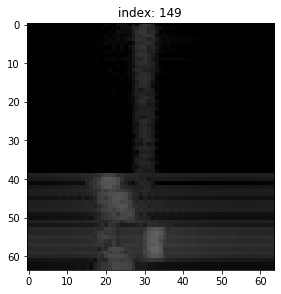

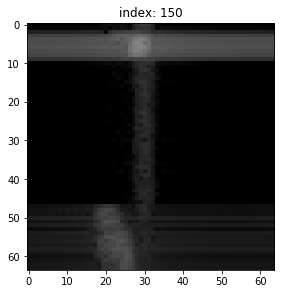

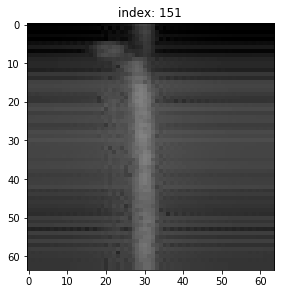

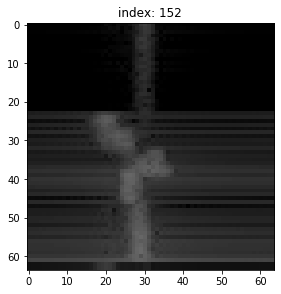

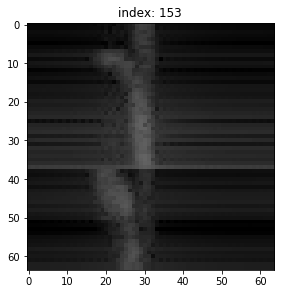

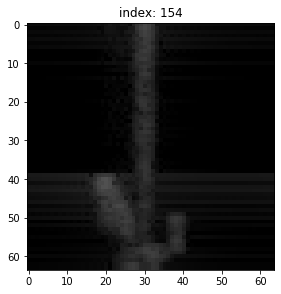

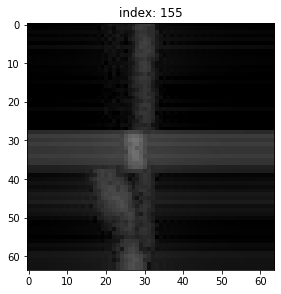

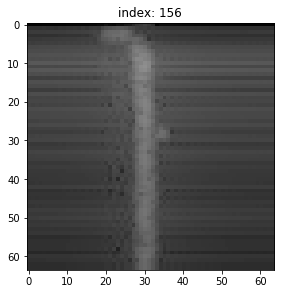

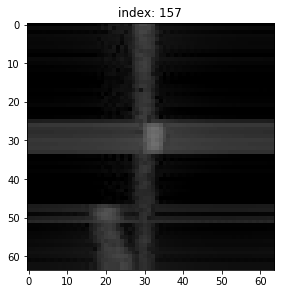

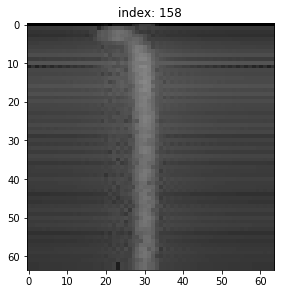

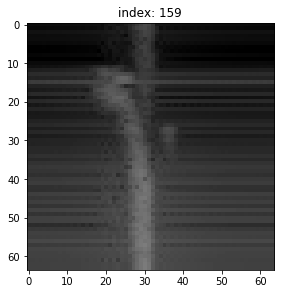

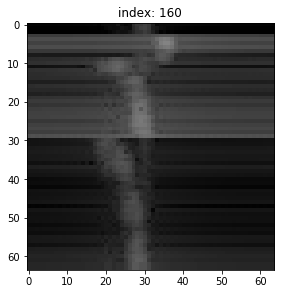

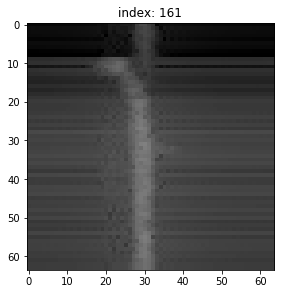

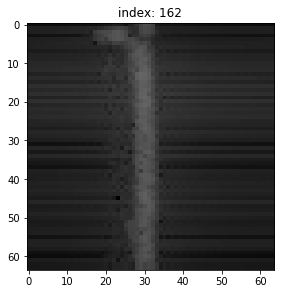

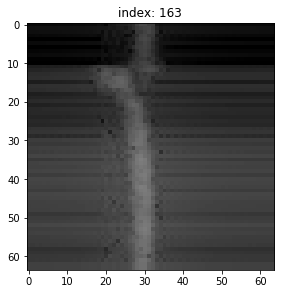

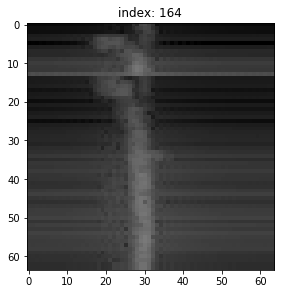

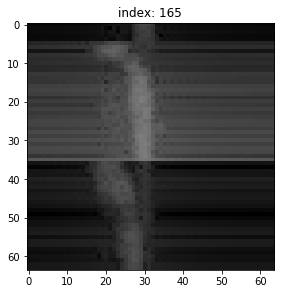

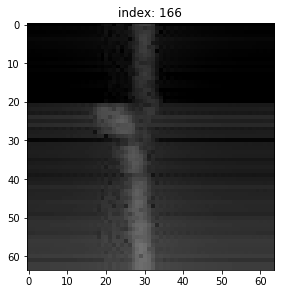

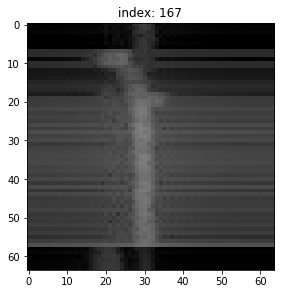

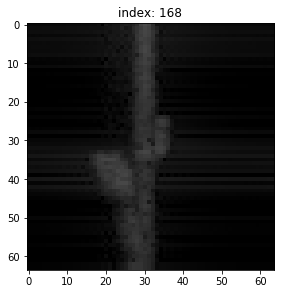

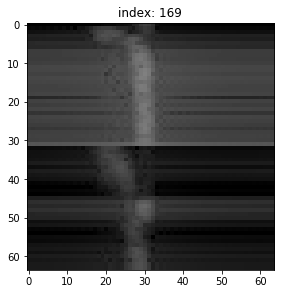

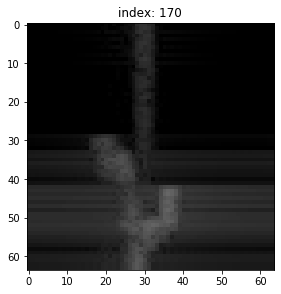

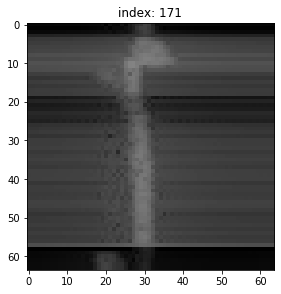

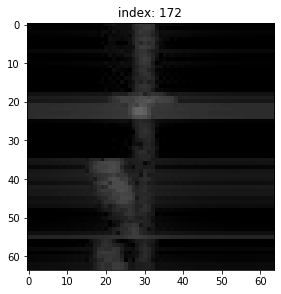

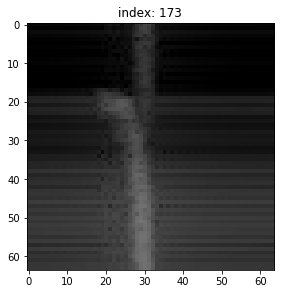

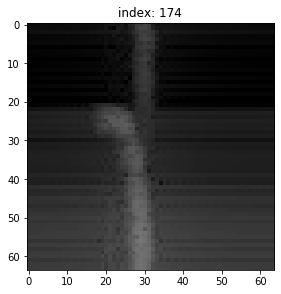

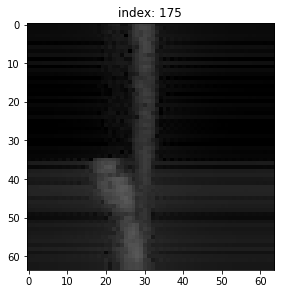

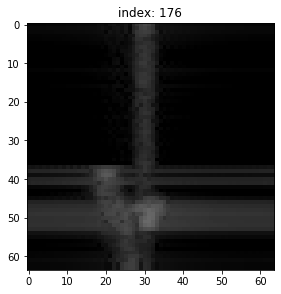

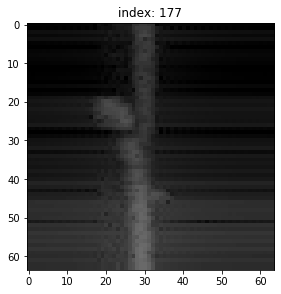

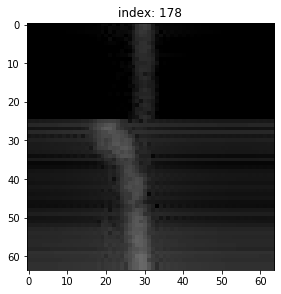

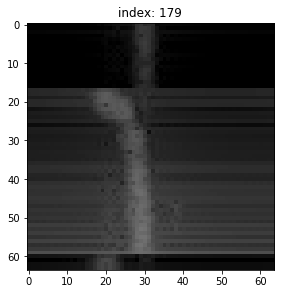

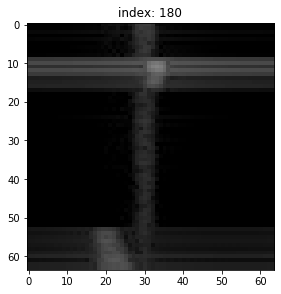

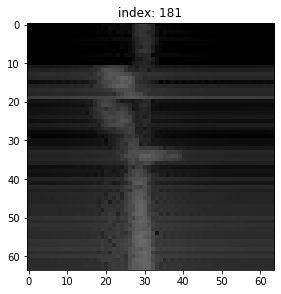

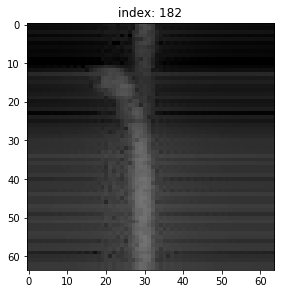

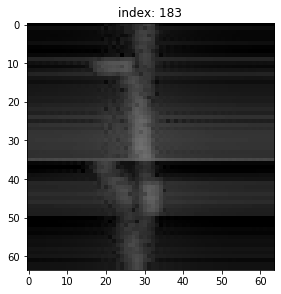

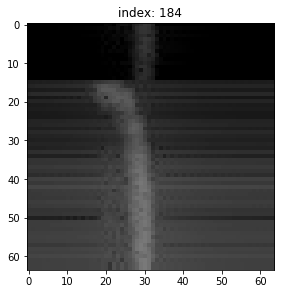

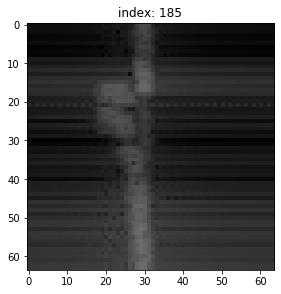

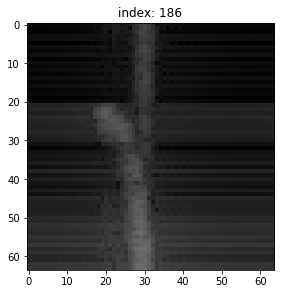

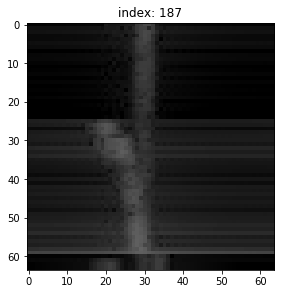

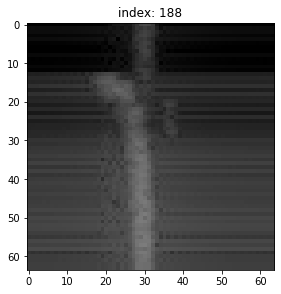

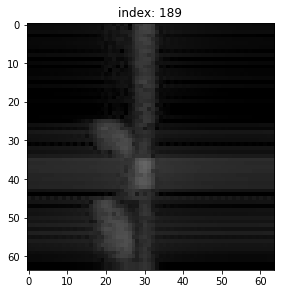

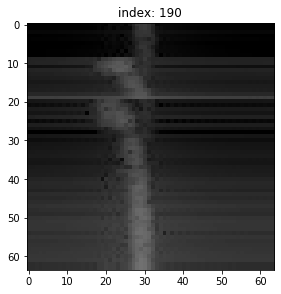

KeyboardInterrupt: 

In [32]:
# show all images
i=0
for img in X_train:
    imshow(img[:,:,15])
    title = "index: " + str(i)
    plt.title(title)
    plt.show()
    i += 1

In [ ]:
# show all masks
for mask in Y_train:
    imshow(np.squeeze(mask))
    plt.show()

In [33]:
# Code to view multiple slices of image
# Credit: https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

In [34]:
# Picked image that looked nice
test = X_train[2,:,:,:]
image_zxy = np.zeros((25, 64, 64))

# Reshaped from 25x64x64 to 64x64x25
for i in range(25):
    image_zxy[i,:,:] = test[:,:,i]

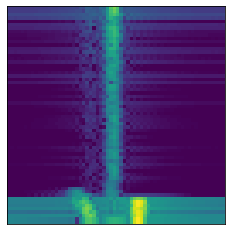

In [35]:
# Call slie viewer
multi_slice_viewer(image_zxy)

# Credits

https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277